# iminuit: A foundational flexible library for fitting

**Author** Hans Dembinski, TU Dortmund, Germany

**Abstract**
I will start with a general introduction into the theory of fitting and why you may want to use iminuit. I will show a few difficult nuts to crack with iminuit, and generally, how you get the best performance for a particular fit. Fitting speed in research matters: if an analysis runs quickly, one can do more checks and variations, and it makes computationally-intensive methods like the bootstrap for error estimation feasible.


## About me

* Particle physicist working with the LHCb experiment
* Formerly astroparticle physicist working with Pierre Auger Observatory and IceCube
* Statistics convener in LHCb (2019-2021, 2024-now)
* Interests
  * Statistics
  * High-performance computing
  * API design: "Make Interfaces Easy to Use Correctly and Hard to Use Incorrectly" *Scott Meyers*

* Memberships
  * [Boost](https://www.boost.org/) project
  * [Scikit-HEP](https://scikit-hep.org/) project
* Author/maintainer
  * [Boost.Histogram (C++)](https://github.com/boostorg/histogram/)
  * [iminuit](https://github.com/scikit-hep/iminuit/)
  * [resample](https://github.com/scikit-hep/resample/)
  * [jacobi](https://github.com/hDembinski/jacobi)
  * [numba-stats](https://github.com/HDembinski/numba-stats)
  * [Chromo](https://github.com/impy-project/chromo)
  * [pyhepmc](https://github.com/scikit-hep/pyhepmc)
* Contributor to scipy and matplotlib

## Introduction

* Fitting?
  * Adjust a **statistical model** to **data set**, find model **parameters** which match data best
  * AI community calls this "learning"
* Dataset: samples $\{ \vec x_i \}$
  * Sample can be one-dimensional or multidimensional
  * Values can be continuous (e.g. candidate mass) or discrete (e.g. bin counts)
* Model: Probability density or probability mass function $f(\vec x; \vec p)$ which depends on unknown parameters $\vec p$

* Conjecture: maximum-likelihood estimate (MLE) $\hat{\vec p} = \text{argmax}_{\vec p} L(\vec p)$ is optimal, with $L(\vec p) = \prod_i f(\vec x_i; \vec p)$
  * **Proven**: Asymptotically optimal, unbiased with minimum variance
    * No proof for finite data sets, but unchallenged
  * **Universal**: MLE can be computed for any problem
  * Equivalent: minimize negative log-likelihood (NLL), $\hat{\vec p} = \text{argmin}_{\vec p}(-\ln L(\vec p))$
* Limiting case of maximum-likelihood fit: **least-squares fit** aka chi-square fit

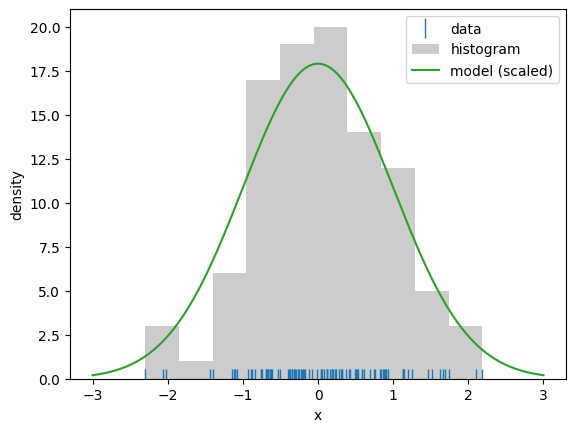

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

dist = norm(0, 1)
x1 = dist.rvs(size=100, random_state=1)
plt.plot(x1, np.zeros_like(x1), "|", ms=15, label="data")
w, xe, *_ = plt.hist(x1, label="histogram", facecolor="0.8")
xm = np.linspace(-3, 3, 1000)
plt.plot(xm, dist.pdf(xm) * len(x1) * (xe[1]-xe[0]), label="model (scaled)")
plt.xlabel("x")
plt.ylabel("density")
plt.legend();

In [2]:
# model pdf
def model1(x, mu, sigma):
    return norm.pdf(x, mu, sigma)

# negative log-likelihood
def nll1(mu, sigma):
    logL = np.log(model1(x1, mu, sigma))
    return -np.sum(logL)

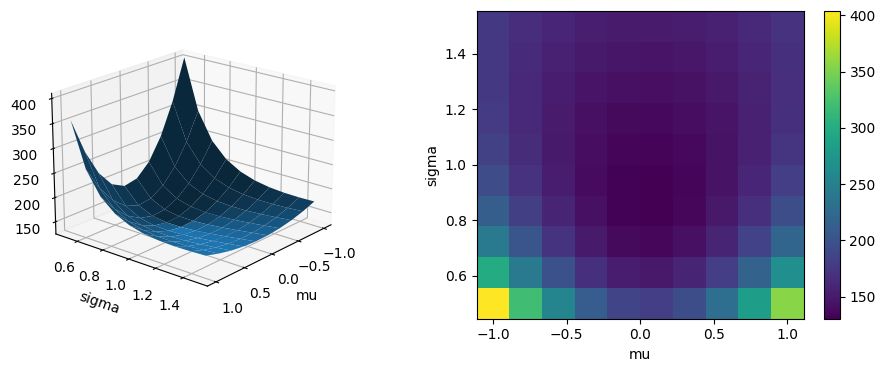

In [3]:
mu = np.linspace(-1, 1, 10)
sigma = np.linspace(0.5, 1.5, 10)
mu2, sigma2 = np.meshgrid(mu, sigma)
z = np.vectorize(nll1)(mu2, sigma2)

plt.figure(figsize=(10, 4))
ax = plt.subplot(121, projection="3d")
ax.view_init(elev=20, azim=40, roll=0)
ax.plot_surface(mu2, sigma2, z)
ax.set(xlabel="mu", ylabel="sigma")
plt.sca(ax)
plt.subplots_adjust(left=0.1, right=1);

ax = plt.subplot(122)
plt.pcolormesh(mu2, sigma2, z)
plt.colorbar()
ax.set(xlabel="mu", ylabel="sigma");

## ![iminuit](https://iminuit.readthedocs.io/en/stable/_images/iminuit_logo.svg)

* Python frontend for C++ Minuit2 library maintained by CERN ROOT team
* Minuit2 is a minimizer developed for negative likelihoods and chi-square functions
* Computes parameter errors via HESSE or MINOS methods
* You can write your own cost function in plain Python
* Jupyter notebook friendly object displays

In [4]:
from iminuit import Minuit

m = Minuit(nll1, mu=0, sigma=1)
m.errordef = Minuit.LIKELIHOOD
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 129.7                      │              Nfcn = 32               │
│ EDM = 3.42e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │   0.06    │   0.09    │            │            │         │         │       │
│ 1 │ sigma │   0.89    │   0.06    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────┐
│       │      mu   sigma │
├───────┼─────────────────┤
│    mu │ 0.00784   0.000 │
│ sigma │   0.000 0.00392 │
└───────┴─────────────────┘

* Bundled extensions
  * Library of common cost functions for various fitting problems
    * `UnbinnedNLL`: maximum-likelihood estimation on unbinned data
    * `BinnedNLL`: maximum-likelihood estimation on binned data
    * `ExtendedUnbinnedNLL` and `ExtendedBinnedNLL`: fit **shape and amplitude**
    * `Template`: fit non-parametric models
    * `NormalConstraint`: penalty terms aka soft constraints
    * `LeastSquares`
  * Wrapper for **scipy minimizers** that handle e.g. **constrained problems**
  * Interactive fitting widget for Jupyter notebooks

In [5]:
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

c = UnbinnedNLL(x1, model1)

m = Minuit(c, mu=0, sigma=1)
m.limits["mu"] = (-2, 2)
m.limits["sigma"] = (0.01, 1.5)
m.interactive()

In [6]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 259.4                      │              Nfcn = 32               │
│ EDM = 2.83e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │   0.06    │   0.09    │            │            │   -2    │    2    │       │
│ 1 │ sigma │   0.89    │   0.06    │            │            │  0.01   │   1.5   │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────┐
│       │      mu   sigma │
├───────┼─────────────────┤
│    mu │ 0.00784   0.000 │
│ sigma │   0.000 0.00392 │
└───────┴─────────────────┘

* iminuit computes parameter errors with the Hesse method and the Minos method
* Hesse method produces symmetric error intervals and covariance matrix
* Minos method produces asymmetric error intervals and 2D contours
* Neither method is superior: use Hesse unless you have strongly asymmetric errors

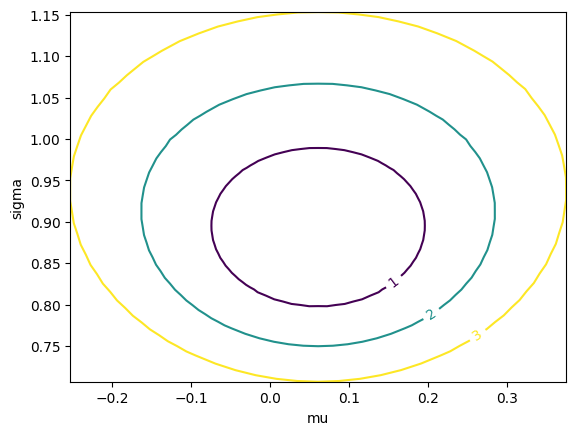

In [7]:
# 1, 2, 3 sigma contours
m.draw_mncontour("mu", "sigma", cl=(1, 2, 3));

## iminuit vs. other packages

* pyhf
  * Better choice when you need to compute limits and preserve the likelihood
* zfit and RooFit
  * Help you build statistical models: automatic normalization & convolutions
    * This has to be done "by hand" in iminuit
  * Good for standard tasks, but restrict your freedom
* iminuit
    * Has very good documentation
    * Modern API design
    * Is very flexible and open
    * Is very fast with numba

## Fast fits with iminuit + numba

* Fast fits are important when...
  * You need an unbinned fit on large sample
  * You have to repeat the same fit many times on different data
    * E.g. fitting many kinematic bins, bootstrapping uncertainties, studying systematic variations


* Performance insights
  * Time spend in minimizer is negligible
  * Bottleneck is evaluating cost function
  * Bottleneck inside cost function is usually evaluation the pdf
  * Cost function is trivially parallelizable: log(pdf) computed independently for each data point
    * Exploit SIMD instructions and parallel computing on multiple cores

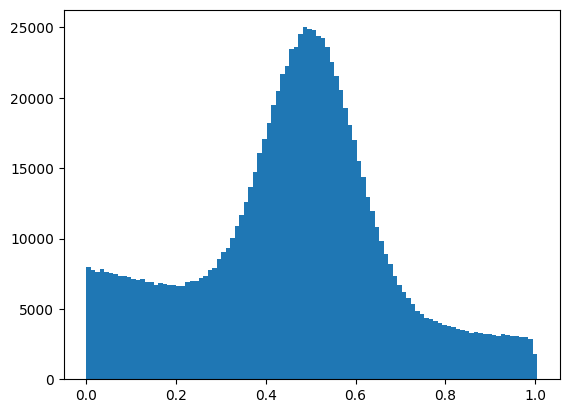

In [8]:
def make_data(size, seed=1):
    rng = np.random.default_rng(seed)
    s = rng.normal(0.5, 0.1, size=size // 2)
    b = rng.exponential(1, size=2 * size)
    b = b[b < 1]
    b = b[: size // 2]
    x = np.append(s, b)
    return x

x2 = make_data(1_000_000)
plt.hist(x2, bins=100);

In [9]:
from numba_stats import norm, truncexpon


def model2(x, z, mu, sigma, slope):
    b = truncexpon.pdf(x, 0.0, 1.0, 0.0, slope)
    s = norm.pdf(x, mu, sigma)
    return (1 - z) * b + z * s


def nll2(z, mu, sigma, slope):
    p = model2(x2, z, mu, sigma, slope)
    return -np.sum(np.log(p))

In [10]:
m = Minuit(nll2, z=0.5, mu=0.5, sigma=1, slope=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.108e+05                 │              Nfcn = 163              │
│ EDM = 2.8e-07 (Goal: 0.0002)     │            time = 6.4 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │  0.4997   │  0.0013   │            │            │         │         │       │
│ 1 │ mu    │ 499.98e-3 │  0.29e-3  │            │            │         │         │       │
│ 2 │ sigma │ 99.59e-3  │  0.29e-3  │            │            │         │         │       │
│ 3 │ slope │   0.997   │   0.008   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────┐
│       │        z       mu    sigma    slope │
├───────┼─────────────────────────────────────┤
│     z │ 1.77e-06 -0.02e-6  0.21e-6  -2.4e-6 │
│    mu │ -0.02e-6 8.36e-08       -0 -0.51e-6 │
│ sigma │  0.21e-6       -0 8.18e-08 -0.37e-6 │
│ slope │  -2.4e-6 -0.51e-6 -0.37e-6 6.12e-05 │
└───────┴─────────────────────────────────────┘

In [11]:
import numba as nb

@nb.njit(inline="always")
def model2(x, z, mu, sigma, slope):
    b = truncexpon.pdf(x, 0.0, 1.0, 0.0, slope)
    s = norm.pdf(x, mu, sigma)
    return (1 - z) * b + z * s


@nb.njit(parallel=True, fastmath=True)
def nll2(z, mu, sigma, slope):
    p = model2(x2, z, mu, sigma, slope)
    return -np.sum(np.log(p))


m = Minuit(nll2, z=0.5, mu=0.5, sigma=1, slope=1)
m.migrad()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.108e+05                 │              Nfcn = 163              │
│ EDM = 2.8e-07 (Goal: 0.0002)     │            time = 9.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │  0.4997   │  0.0013   │            │            │         │         │       │
│ 1 │ mu    │ 499.98e-3 │  0.29e-3  │            │            │         │         │       │
│ 2 │ sigma │ 99.59e-3  │  0.29e-3  │            │            │         │         │       │
│ 3 │ slope │   0.997   │   0.008   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────┐
│       │        z       mu    sigma    slope │
├───────┼─────────────────────────────────────┤
│     z │ 1.77e-06 -0.02e-6  0.21e-6  -2.4e-6 │
│    mu │ -0.02e-6 8.36e-08       -0 -0.51e-6 │
│ sigma │  0.21e-6       -0 8.18e-08 -0.37e-6 │
│ slope │  -2.4e-6 -0.51e-6 -0.37e-6 6.12e-05 │
└───────┴─────────────────────────────────────┘

In [12]:
m = Minuit(nll2, z=0.5, mu=0.5, sigma=1, slope=1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.108e+05                 │              Nfcn = 163              │
│ EDM = 2.8e-07 (Goal: 0.0002)     │            time = 1.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ z     │  0.4997   │  0.0013   │            │            │         │         │       │
│ 1 │ mu    │ 499.98e-3 │  0.29e-3  │            │            │         │         │       │
│ 2 │ sigma │ 99.59e-3  │  0.29e-3  │            │            │         │         │       │
│ 3 │ slope │   0.997   │   0.008   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────┐
│       │        z       mu    sigma    slope │
├───────┼─────────────────────────────────────┤
│     z │ 1.77e-06 -0.02e-6  0.21e-6  -2.4e-6 │
│    mu │ -0.02e-6 8.36e-08       -0 -0.51e-6 │
│ sigma │  0.21e-6       -0 8.18e-08 -0.37e-6 │
│ slope │  -2.4e-6 -0.51e-6 -0.37e-6 6.12e-05 │
└───────┴─────────────────────────────────────┘

[Plots from the iminuit benchmarks](https://iminuit.readthedocs.io/en/stable/benchmark.html)

![](numba_vs_scipy.svg)

![](https://iminuit.readthedocs.io/en/stable/_images/overhead.svg)

![](roofit_vs_iminuit.svg)

## Binned vs. unbinned fits

* Idea: don't fit original data sample, fit histogram of data sample
  * Histogram: **lossy compression** of original data
  * Another way to speed up fitting
* Fit results based on histograms not more biased, but may have larger variance
* Loss can be made **negligible** with sufficiently fine binning
* Binned fits require the modeling **cdf** instead of **pdf**
* Further benefit: iminuit cost functions compute **chi-square goodness-of-fit test statistic** for free, based on [S. Baker and RD. Cousins,     Nucl.Instrum.Meth. 221 (1984) 437-442](https://doi.org/10.1016/0167-5087(84)90016-4)

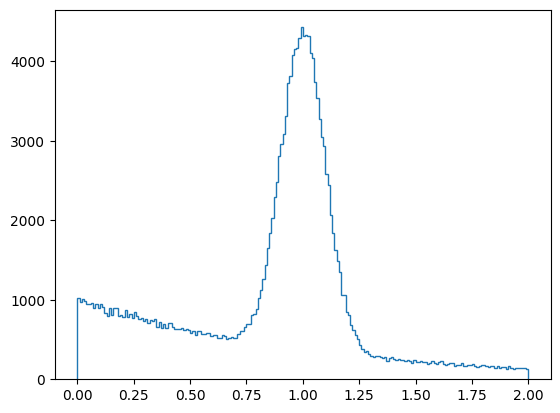

In [13]:
n = 100_000
truth = np.array((1.0, 1.0, 1.0, 0.1, 1.0))
rng = np.random.default_rng(1)
s = rng.normal(truth[2], truth[3], size=int(n * truth[0]))
b = rng.exponential(truth[4], size=int(n * truth[1]))
x3 = np.append(s, b)
x3 = x3[(x3 > 0) & (x3 < 2)]

w, xe = np.histogram(x3, bins=200)  # for more complex histograms use boost-histogram
plt.stairs(w, xe);

In [14]:
from numba_stats import norm, expon
from iminuit.cost import ExtendedBinnedNLL

def model3(xe, s, b, mu, sigma, tau):
    return s * n * norm.cdf(xe, mu, sigma) + b * n * expon.cdf(xe, 0, tau)

In [15]:
c = ExtendedBinnedNLL(w, xe, model3)
m = Minuit(c, *truth)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 190.9 (χ²/ndof = 1.0)      │              Nfcn = 110              │
│ EDM = 2.26e-06 (Goal: 0.0002)    │            time = 0.5 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │   0.995   │   0.004   │            │            │         │         │       │
│ 1 │ b     │   1.008   │   0.005   │            │            │         │         │       │
│ 2 │ mu    │ 999.3e-3  │  0.4e-3   │            │            │         │         │       │
│ 3 │ sigma │ 99.22e-3  │  0.34e-3  │            │            │         │         │       │
│ 4 │ tau   │   1.002   │   0.007   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────────────────────────┐
│       │         s         b        mu     sigma       tau │
├───────┼───────────────────────────────────────────────────┤
│     s │  1.32e-05 -0.005e-3  -0.04e-6   0.30e-6 -0.004e-3 │
│     b │ -0.005e-3  2.37e-05         0  -0.47e-6  0.020e-3 │
│    mu │  -0.04e-6         0  1.46e-07  -0.01e-6  -0.14e-6 │
│ sigma │   0.30e-6  -0.47e-6  -0.01e-6  1.12e-07  -0.37e-6 │
│   tau │ -0.004e-3  0.020e-3  -0.14e-6  -0.37e-6  4.77e-05 │
└───────┴───────────────────────────────────────────────────┘

* [Full study can be reviewed in iminuit docs](https://iminuit.readthedocs.io/en/stable/notebooks/binned_vs_unbinned.html)
* 100k data points
* Normal signal + truncated exponential background
* Bins: infinite (unbinned likelihood), 200, 100, 50, 20, 10, 5
* Study bias and variance of fit results
  * Repeatedly fit random data sets of equal size

![](variable_binning_fits.png)

![](variable_binning_results.png)

![](variable_binning_speedup.png)

## Template fits

* Sometimes PDF/CDF not known in parametric form, but can be Monte-Carlo simulated
* Idea: fit a histogram of simulation output (template) to data histogram
* Additional source of uncertainty from finite size of simulation
* Correct error propagation with Barlow-Beeston method, [Barlow and Beeston, Comput.Phys.Commun. 77 (1993) 219-228](https://doi.org/10.1016/0010-4655(93)90005-W)
* `iminuit.cost.Template`
  * Extension to weighted data and simuation, [H. Dembinski, A. Abdelmotteleb, Eur.Phys.J.C 82 (2022) 11, 1043](https://doi.org/10.1140/epjc/s10052-022-11019-z)
  * Approximation to Barlow-Beeston method for unweighted data
  * Faster computation
  * Allows you to mix parametric models and templates

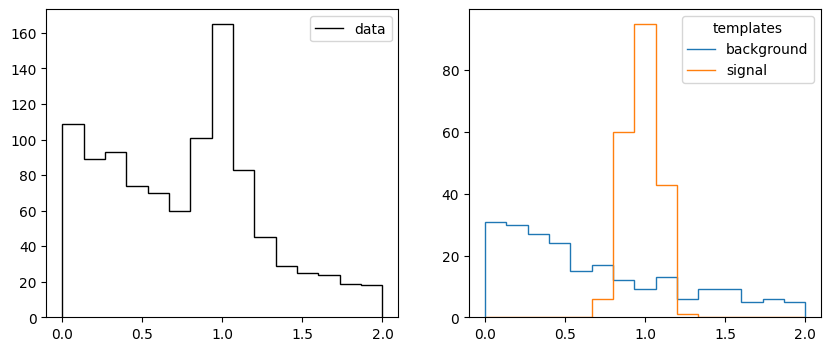

In [16]:
def generate(rng, nmc, truth, bins):
    xe = np.linspace(0, 2, bins + 1)
    b = np.diff(truncexpon.cdf(xe, 0, 2, 0, 1))
    s = np.diff(norm.cdf(xe, 1, 0.1))
    n = rng.poisson(b * truth[0]) + rng.poisson(s * truth[1])
    t = np.array([rng.poisson(b * nmc), rng.poisson(s * nmc)])
    return xe, n, t

rng = np.random.default_rng(1)
truth = 750, 250
xe, n, t = generate(rng, 200, truth, 15)

_, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].stairs(n, xe, color="k", label="data")
ax[0].legend();
ax[1].stairs(t[0], xe, label="background")
ax[1].stairs(t[1], xe, label="signal")
ax[1].legend(title="templates");

In [17]:
from iminuit.cost import Template

c = Template(n, xe, t)
m = Minuit(c, 1, 1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8.511 (χ²/ndof = 0.7)      │              Nfcn = 124              │
│ EDM = 3.22e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    760    │    60     │            │            │    0    │         │       │
│ 1 │ x1   │    249    │    34     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │       x0       x1 │
├────┼───────────────────┤
│ x0 │ 3.98e+03   -0.6e3 │
│ x1 │   -0.6e3 1.13e+03 │
└────┴───────────────────┘

In [18]:
xe, n, t = generate(rng, 1_000_000, truth, 15)

c = Template(n, xe, t)
m = Minuit(c, 1, 1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.32 (χ²/ndof = 0.9)      │              Nfcn = 110              │
│ EDM = 5.76e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │    782    │    31     │            │            │    0    │         │       │
│ 1 │ x1   │    238    │    20     │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────┐
│    │     x0     x1 │
├────┼───────────────┤
│ x0 │    960 -0.2e3 │
│ x1 │ -0.2e3    416 │
└────┴───────────────┘

## Summary

* iminuit is a versatile, fast, easy-to-use library for fitting
* Builtin cost functions cover most common use-cases
* Emphasis is put on having excellent documentation and being bug-free
* Due to its focussed open design
  * Preferred by statistics experts (e.g. Glen Cowan)
  * Excellent for teaching
* Excellent performance in combination with numba and numba-stats
* Easy installation: **binary wheels** for all major platforms (Python-3.12 will be added in next release)